# Import statements

In [1]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

from sklearn.model_selection import train_test_split

from sklearn.pipeline import  Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator

import category_encoders as ce
from sklearn.preprocessing import KBinsDiscretizer, Binarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix


#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

# Load original data

In [2]:
file_path = os.path.join('data', 'train.csv')

# Option for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0, 
                             #nrows = 10000, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    # Drop observations correspoding to stops that didn't lead to a search
    df = df_original[df_original.VehicleSearchedIndicator==True].reset_index(drop=True).drop(columns='VehicleSearchedIndicator')


# Train-Test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='ContrabandIndicator'), 
                                                    df['ContrabandIndicator'], 
                                                    test_size=0.6, 
                                                    random_state=42)

# Pipeline workflow

In [4]:
# Custom transformer to implement sentence cleaning
class TextCleanerTransformer(TransformerMixin):
    def __init__(self, 
                 regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")], 
                 lower=True, 
                 remove_punct=True):
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        #X = list(map(self._clean_sentence, X.values))
        X_copy = X.copy()
        X_copy = X_copy.applymap(self._clean_sentence)
        return X_copy
    
    def _clean_sentence(self, sentence):
        
        # Make sure it is a string!
        sentence = str(sentence)
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()
        
        # Trim
        sentence = sentence.strip()
        
        return sentence
    
    def fit(self, *_):
        return self

In [5]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

    
class BoolSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

In [24]:
text_pipe = Pipeline([
                ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
                ('ordinalencoder', ce.ordinal.OrdinalEncoder()),
                ('handle_unknown_imputer', SimpleImputer(missing_values=-1, strategy='most_frequent')),
                ('handle_missing_imputer1', SimpleImputer(missing_values=-2, strategy='most_frequent')),
            ])

numerical_pipe =  Pipeline([
                ('selector', NumberSelector(['SubjectAge'])),
                ('binarizer', Binarizer(threshold=27)),
                ('handle_missing_imputer1', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
            ])

# Feature Union allow use to use multiple distinct features in our classifier
feats = FeatureUnion([('text', text_pipe), 
                      ('numerical', numerical_pipe)])

pipe_clf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

# train the classifier
pipe_clf.fit(X_train, y_train)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('selector', TextSelector(key=['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])), ('ordinalencoder', OrdinalEncoder(cols=['Department Name', 'SearchAuthorizationCode', 'St...mators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

# Define a fair threshold

Predict probability of the training samples

In [26]:
decision_thr = 0.5
y_prob_train = pipe_clf.predict_proba(X_train)[:,1]
y_pred_train = y_prob_train > decision_thr

### Metrics among protected classes in the training set using threshold 0.5

In [27]:
df_train_classes = pd.DataFrame({X_train.SubjectRaceCode.name: X_train.SubjectRaceCode, 
                                X_train.SubjectEthnicityCode.name: X_train.SubjectEthnicityCode, 
                                X_train.SubjectSexCode.name: X_train.SubjectSexCode,
                                'y_prob': y_prob_train,                                 
                                'y_pred': y_pred_train,
                                'y_true': y_train})

In [32]:
#sanity check
assert df_train_classes.shape[0] == X_train.shape[0]

In [33]:
train_race_results = df_train_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
train_ethnic_results = df_train_classes.groupby(['SubjectEthnicityCode','y_true', 'y_pred']).SubjectEthnicityCode.count()
train_sex_results = df_train_classes.groupby(['SubjectSexCode','y_true', 'y_pred']).SubjectSexCode.count()

In [37]:
assert train_race_results[:,True,:].sum() == train_ethnic_results[:,True,:].sum() == train_sex_results[:,True,:].sum() == y_train.sum()

In [40]:
assert train_race_results[:,:,True].sum() == train_ethnic_results[:,:,True].sum() == train_sex_results[:,:,True].sum() == y_pred_train.sum()

In [41]:
df_train_classes.head(10)

,SubjectRaceCode,SubjectEthnicityCode,SubjectSexCode,y_prob,y_pred,y_true
38894,W,H,M,0.030179,False,False
8459,A,N,M,0.000000,False,False
9098,W,M,M,0.308388,False,False
52801,B,N,M,0.117050,False,False
30352,W,N,F,0.748077,True,True
678,W,N,M,0.248244,False,False
36494,W,N,F,0.900000,True,True
51729,W,N,M,0.100000,False,False
45364,B,N,M,0.580089,True,True
12013,W,H,M,0.191315,False,True


### Precision overall

In [54]:
precision_train = precision_score(y_train, y_pred_train)
precision_train

0.7152889707575408

In [55]:
# Sanity check
assert df_train_classes[df_train_classes.y_pred==True].y_true.mean() == precision_train

### Precision among races ('SubjectRaceCode': 'race')

Precision table:

In [92]:
df_train_classes[df_train_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)

SubjectRaceCode
A    64.179104
B    67.683713
I    60.869565
W    73.073855
Name: y_true, dtype: float64

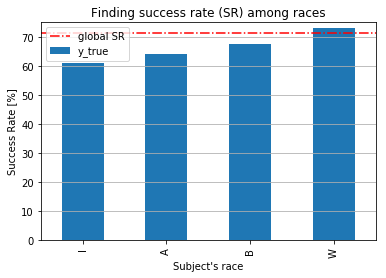

In [56]:
(df_train_classes[df_train_classes.y_pred==True].groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision_train*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among ethnicities ('SubjectEthnicityCode': 'ethnic')

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

Precision table:

In [165]:
df_train_classes[df_train_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)

SubjectEthnicityCode
H    67.609874
M    63.636364
N    72.539158
Name: y_true, dtype: float64

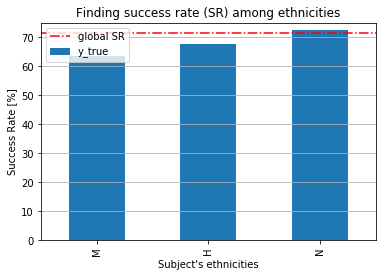

In [166]:
(df_train_classes[df_train_classes.y_pred==True].groupby('SubjectEthnicityCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision_train*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicities")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among sexes ('SubjectSexCode': 'sex')

Precision table:

In [167]:
df_train_classes[df_train_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)

SubjectSexCode
F    70.222222
M    71.818310
Name: y_true, dtype: float64

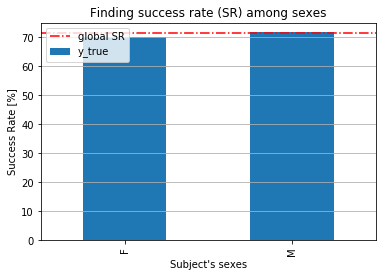

In [168]:
(df_train_classes[df_train_classes.y_pred==True].groupby('SubjectSexCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision_train*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sexes")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

## Train a fair threshold

In [161]:
def train_thr_for_classes(df_with_classes, class_feature):
    
    classes = df_with_classes[class_feature].unique().tolist()
    threshold_series = pd.Series(np.ones(len(classes)), index=classes, name='thresholds')
    
    max_precision = df_with_classes[df_with_classes.y_pred==True].groupby(class_feature).y_true.mean().max()
    max_precision_class = df_with_classes[df_with_classes.y_pred==True].groupby(class_feature).y_true.mean().idxmax()
    
    for idx in classes:

        if idx == max_precision_class:
            threshold_series[idx] = 0.5

        else:            
            for thr in np.arange(0.5,1,0.005):

                new_precision_series = df_with_classes[df_with_classes.y_prob > thr].groupby(class_feature).y_true.mean()
                new_class_precision = new_precision_series[idx] 
                #print(idx, thr, new_class_precision)
                
                #if max_precision - new_class_precision < 0.001:
                if 1 - new_class_precision/max_precision < 0.001:
                    break

            threshold_series[idx] = thr
            
    return threshold_series


In [162]:
race_threshold = train_thr_for_classes(df_train_classes , 'SubjectRaceCode')
race_threshold

W    0.500
A    0.610
B    0.585
I    0.830
Name: thresholds, dtype: float64

In [163]:
ethnic_threshold = train_thr_for_classes(df_train_classes , 'SubjectEthnicityCode')
ethnic_threshold

H    0.590
N    0.500
M    0.585
Name: thresholds, dtype: float64

In [164]:
sex_threshold = train_thr_for_classes(df_train_classes , 'SubjectSexCode')
sex_threshold

M    0.500
F    0.525
Name: thresholds, dtype: float64

## Classifier using a fair threshold

In [184]:
protected_classes = ['SubjectRaceCode', 'SubjectEthnicityCode', 'SubjectSexCode']

thresholds_df = df_train_classes[protected_classes]

thresholds_df['SubjectRaceCode'] = thresholds_df.SubjectRaceCode.map(race_threshold)
thresholds_df['SubjectEthnicityCode'] = thresholds_df.SubjectEthnicityCode.map(ethnic_threshold)
thresholds_df['SubjectSexCode'] = thresholds_df.SubjectSexCode.map(sex_threshold)

thresholds_df['max_thr'] = thresholds_df.max(axis=1)

thresholds_df

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,SubjectRaceCode,SubjectEthnicityCode,SubjectSexCode,max_thr
38894,0.500,0.590,0.500,0.590
8459,0.610,0.500,0.500,0.610
9098,0.500,0.585,0.500,0.585
52801,0.585,0.500,0.500,0.585
30352,0.500,0.500,0.525,0.525
678,0.500,0.500,0.500,0.500
36494,0.500,0.500,0.525,0.525
51729,0.500,0.500,0.500,0.500
45364,0.585,0.500,0.500,0.585
12013,0.500,0.590,0.500,0.590


In [190]:
(df_train_classes[df_train_classes.y_prob > thresholds_df.max_thr].groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100))

SubjectRaceCode
A    73.170732
B    73.274336
I    75.000000
W    74.904148
Name: y_true, dtype: float64

# Fair classifier performance

In [193]:

# Compute class probability in the test set
y_prob = pipe_clf.predict_proba(X_test)[:,1]


# Define the individual thresholds

thresholds_df = X_test[['SubjectRaceCode', 'SubjectEthnicityCode', 'SubjectSexCode']]

thresholds_df['SubjectRaceCode'] = thresholds_df.SubjectRaceCode.map(race_threshold)
thresholds_df['SubjectEthnicityCode'] = thresholds_df.SubjectEthnicityCode.map(ethnic_threshold)
thresholds_df['SubjectSexCode'] = thresholds_df.SubjectSexCode.map(sex_threshold)

thresholds_df['max_thr'] = thresholds_df.max(axis=1)

# Predict class
y_pred = y_prob > thresholds_df.max_thr

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a cop

# Metrics

In [194]:
y_true = y_test

In [195]:
precision = precision_score(y_true, y_pred)
precision

0.617514374170721

In [196]:
recall = recall_score(y_true, y_pred)
recall

0.4538421531660382

In [197]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.7236459192980932

In [198]:
cf = confusion_matrix(y_true, y_pred)
TN = cf[0][0]
TP = cf[1][1]
FN = cf[1][0]
FP = cf[0][1]

Sanity checks:

In [199]:
precision == TP/(TP+FP) 

True

In [200]:
recall == TP/(TP+FN)

True

In [201]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.76      0.86      0.81     30664
        True       0.62      0.45      0.52     15382

   micro avg       0.72      0.72      0.72     46046
   macro avg       0.69      0.66      0.66     46046
weighted avg       0.71      0.72      0.71     46046



In [202]:
y_pred.sum()/y_pred.shape[0]

0.2455153542110064

In [203]:
y_true.sum()

15382

# Curves

In [204]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
AUROC = roc_auc_score(y_true, y_prob)*100

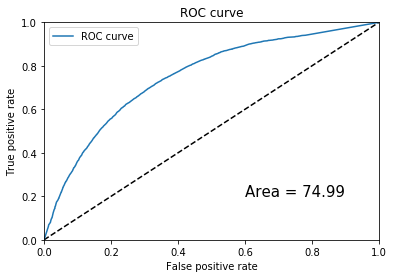

In [205]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.legend(loc='best')
plt.show()

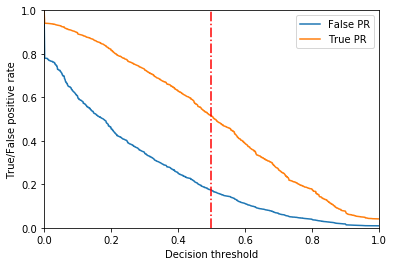

In [206]:
plt.figure(2)
plt.plot(thresholds_roc, fpr , label='False PR')
plt.plot(thresholds_roc, tpr, label='True PR')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
#plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [207]:
precision_vec, recall_vec, thresholds_pr = precision_recall_curve(y_true, y_prob)

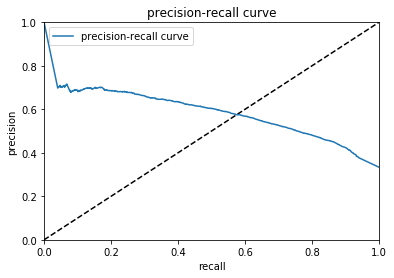

In [208]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_vec, precision_vec, label='precision-recall curve')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

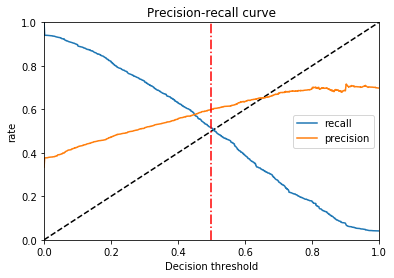

In [209]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds_pr, recall_vec[:-1] , label='recall')
plt.plot(thresholds_pr, precision_vec[:-1], label='precision')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('rate')
plt.title('Precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [210]:
df_results = y_test.to_frame(name='y_true')
df_results['y_pred'] = y_pred
df_results['y_prob'] = y_prob
df_results.head()

,y_true,y_pred,y_prob
30717,False,False,0.355556
44889,True,True,0.842211
13938,False,False,0.308561
20220,False,False,0.458966
21837,True,True,0.708333


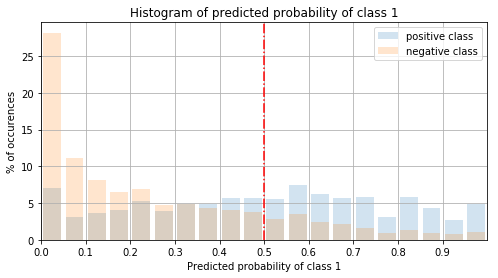

In [211]:
n_trues = df_results[df_results.y_true==True].shape[0]
n_falses = df_results[df_results.y_true==False].shape[0]

plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, weights=np.ones(n_trues)/n_trues*100, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, weights=np.ones(n_falses)/n_falses*100, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("% of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

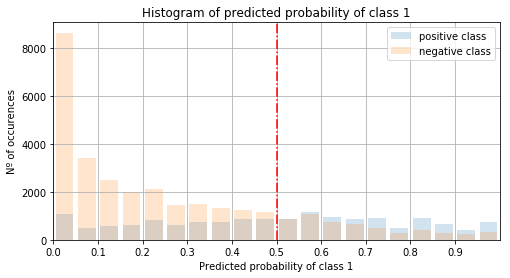

In [212]:
plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Nº of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

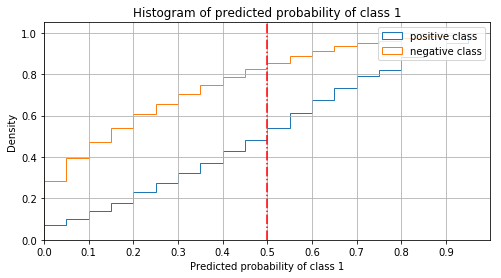

In [213]:
df_results[df_results.y_true==True].y_prob.hist(bins=20, figsize=(8,4), histtype='step',label='positive class', density=True, cumulative=True)
df_results[df_results.y_true==False].y_prob.hist(bins=20, figsize=(8,4), histtype='step', label='negative class', density=True, cumulative=True)

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Density")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

In [214]:
df_results.set_index('y_prob').y_true

y_prob
0.355556    False
0.842211     True
0.308561    False
0.458966    False
0.708333     True
0.000000    False
0.057460    False
0.282269    False
0.344168    False
0.804051     True
0.000000    False
0.000000    False
0.433900     True
0.000000    False
0.416667     True
0.479296    False
0.204195    False
0.097471    False
0.000000    False
0.766692     True
0.537499     True
0.000000    False
0.403660    False
0.430556     True
0.200000    False
0.094979    False
0.576674    False
0.255201    False
0.833023     True
0.181569    False
            ...  
0.897500     True
0.000000    False
0.262657    False
0.000000    False
0.514135     True
0.291190    False
0.246688     True
0.283333    False
0.215925     True
0.300400    False
0.200000     True
0.576667     True
0.886763     True
0.510183    False
0.509524    False
0.255833     True
0.833023     True
0.032282    False
0.000000    False
0.214286    False
0.000000    False
0.160128    False
0.000000    False
0.630493     True
0.7

### Predict all `True`

In [215]:
y_pred_true = np.ones(y_test.shape).astype(bool)

In [216]:
precision_score(y_test, y_pred_true)

0.3340572471007254

In [217]:
recall_score(y_test, y_pred_true)

1.0

In [218]:
accuracy_score(y_test, y_pred_true)

0.3340572471007254

### Predict all `False`

In [219]:
y_pred_false = np.zeros(y_test.shape).astype(bool)

In [220]:
precision_score(y_test, y_pred_false)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [221]:
recall_score(y_test, y_pred_false)

0.0

In [222]:
accuracy_score(y_test, y_pred_false)

0.6659427528992746

### Predict randomly with positive\negative ratio `r`

In [223]:
np.random.seed(425)
ratio = 0.10

In [224]:
# y_pred_rand = np.random.randint(2, size=y_test.shape).astype(bool)
y_pred_rand = np.random.binomial(n=1, p=ratio, size=y_test.shape).astype(bool)

Percentage of searches

In [225]:
y_pred_rand.sum()/y_pred_rand.shape[0]

0.09946575163966469

In [226]:
precision_score(y_test, y_pred_rand)

0.3299126637554585

In [227]:
recall_score(y_test, y_pred_rand)

0.09823169938889612

In [228]:
accuracy_score(y_test, y_pred_rand)

0.6321070234113713

# Metrics among protected classes

In [229]:
df_test_classes = pd.DataFrame({X_test.SubjectRaceCode.name: X_test.SubjectRaceCode, 
                                X_test.SubjectEthnicityCode.name: X_test.SubjectEthnicityCode, 
                                X_test.SubjectSexCode.name: X_test.SubjectSexCode, 
                                'y_true': y_true, 
                                'y_pred': y_pred})

In [230]:
#sanity check
df_test_classes.shape[0] == X_test.shape[0]

True

In [231]:
test_race_results = df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
test_ethnic_results = df_test_classes.groupby(['SubjectEthnicityCode','y_true', 'y_pred']).SubjectEthnicityCode.count()
test_sex_results = df_test_classes.groupby(['SubjectSexCode','y_true', 'y_pred']).SubjectSexCode.count()

Sanity checks:

In [232]:
test_race_results[:,True,:].sum() == test_ethnic_results[:,True,:].sum() == test_sex_results[:,True,:].sum() == y_true.sum()

True

In [233]:
test_race_results[:,:,True].sum() == test_ethnic_results[:,:,True].sum() == test_sex_results[:,:,True].sum() == y_pred.sum()

True

In [234]:
df_test_classes.head(10)

,SubjectRaceCode,SubjectEthnicityCode,SubjectSexCode,y_true,y_pred
30717,B,N,F,False,False
44889,W,N,F,True,True
13938,W,N,M,False,False
20220,A,N,M,False,False
21837,W,H,M,True,True
54524,W,H,M,False,False
72386,B,N,F,False,False
28592,W,N,M,False,False
52567,B,N,F,False,False
73072,B,N,M,True,True


### Precision overall

In [235]:
precision_score(y_true, y_pred)

0.617514374170721

In [236]:
# Sanity check
df_test_classes[df_test_classes.y_pred==True].y_true.mean()

0.617514374170721

### Precision among races

In [259]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').SubjectRaceCode.count()

SubjectRaceCode
A      61
B    2584
I       7
W    8653
Name: SubjectRaceCode, dtype: int64

Precision table:

In [256]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().drop('I').apply(lambda x: x*100)

SubjectRaceCode
A    59.016393
B    56.462848
W    63.342193
Name: y_true, dtype: float64

Max. difference:

In [257]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().drop('I').max() - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().drop('I').min())*100

6.879345161702366

Max. difference [%]:

In [239]:
(1 - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().min() / df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().max())*100

20.952012383900932

In [240]:
1-93/99

0.06060606060606055

Standard difference:

In [241]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100).std()

6.5573309376598585

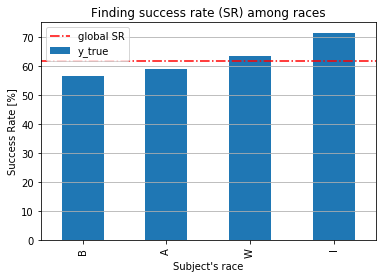

In [242]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among ethnicities

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

Precision table:

In [243]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)

SubjectEthnicityCode
H    61.534306
M    55.737705
N    61.833280
Name: y_true, dtype: float64

Max. difference:

In [244]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().max() - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().min())*100

6.095575184170987

Max. difference [%]:

In [245]:
(1 - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().min() / df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().max())*100

9.85808156076413

Standard difference:

In [246]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100).std()

3.4362286505078132

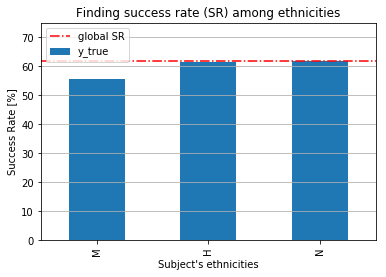

In [247]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicities")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among sexes

Precision table:

In [248]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)

SubjectSexCode
F    63.101079
M    61.454624
Name: y_true, dtype: float64

Max. difference [p.p.]:

In [249]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().max() - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().min())*100

1.6464555553049265

Max. difference [%]:

In [250]:
(1 - df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().min() / df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().max())*100

2.6092351646278655

Standard difference:

In [251]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100).std()

1.1642198880783754

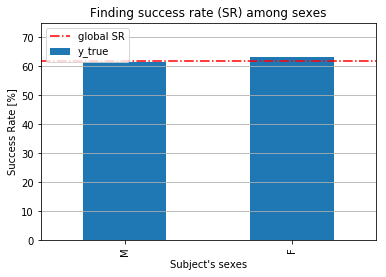

In [252]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sexes")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Recall overall

In [83]:
recall_score(y_true, y_pred)

0.514367442465219

In [84]:
# Sanity check
df_test_classes[df_test_classes.y_true==True].y_pred.mean()

0.514367442465219

In [85]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectRaceCode').y_pred.mean()

SubjectRaceCode
A    0.522727
B    0.491341
I    0.547619
W    0.522480
Name: y_pred, dtype: float64

In [86]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectEthnicityCode').y_pred.mean()

SubjectEthnicityCode
H    0.497281
M    0.318471
N    0.520964
Name: y_pred, dtype: float64

In [87]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectSexCode').y_pred.mean()

SubjectSexCode
F    0.534066
M    0.510117
Name: y_pred, dtype: float64

In [88]:
df_test_classes.groupby('SubjectRaceCode')[['y_true', 'y_pred']]

In [89]:
df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred'])[['y_true', 'y_pred']]

In [90]:
test_race_results

SubjectRaceCode  y_true  y_pred
A                False   False       180
                         True         38
                 True    False        42
                         True         46
B                False   False      7856
                         True       1637
                 True    False      2056
                         True       1986
I                False   False        79
                         True         12
                 True    False        19
                         True         23
W                False   False     17271
                         True       3591
                 True    False      5353
                         True       5857
Name: SubjectRaceCode, dtype: int64

In [91]:
test_race_results.loc[:,:,True]

SubjectRaceCode  y_true
A                False       38
                 True        46
B                False     1637
                 True      1986
I                False       12
                 True        23
W                False     3591
                 True      5857
Name: SubjectRaceCode, dtype: int64

### Precision by class

In [92]:
test_race_results = df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
test_race_results

SubjectRaceCode  y_true  y_pred
A                False   False       180
                         True         38
                 True    False        42
                         True         46
B                False   False      7856
                         True       1637
                 True    False      2056
                         True       1986
I                False   False        79
                         True         12
                 True    False        19
                         True         23
W                False   False     17271
                         True       3591
                 True    False      5353
                         True       5857
Name: SubjectRaceCode, dtype: int64

In [93]:
test_race_results.loc[:,False,:]

SubjectRaceCode  y_pred
A                False       180
                 True         38
B                False      7856
                 True       1637
I                False        79
                 True         12
W                False     17271
                 True       3591
Name: SubjectRaceCode, dtype: int64

In [94]:
# sanity check
df_test_race.y_true.sum() == y_test.sum() and df_test_race.y_pred.sum() == y_pred.sum()

NameError: name 'df_test_race' is not defined

In [ ]:
df_test_race.y_true.sum()

In [ ]:
y_test.sum()

In [ ]:
recall = recall_score(y_test, y_pred)
recall

In [ ]:
df_test_classes = pd.DataFrame({X_test.SubjectRaceCode.name: X_test.SubjectRaceCode, 
                                X_test.SubjectEthnicityCode.name: X_test.SubjectEthnicityCode, 
                                X_test.SubjectSexCode.name: X_test.SubjectSexCode, 
                                'y_true': y_test ,
                                'y_pred': y_pred})
df_test_classes

In [ ]:
5278/(5278+7912)

In [ ]:
confusion_matrix(y_test, y_pred)